In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/Dataset'

if os.path.exists(base_dir):
    print(f"Klasör bulundu: {base_dir}")
    print("İçerik:", os.listdir(base_dir))
else:
    print("Klasör bulunamadı! Lütfen Drive yolunu kontrol edin.")

Mounted at /content/drive
Klasör bulundu: /content/drive/MyDrive/Dataset
İçerik: ['Testing', 'Training']


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

!pip install keras_preprocessing
!pip install -q keras-tuner

import keras_tuner as kt

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.regularizers import l2
# Uyarıları kapat
warnings.filterwarnings("ignore")
print("Kütüphaneler yüklendi.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.4 MB/s eta 0:00:00
Kütüphaneler yüklendi.


In [ ]:
# --- EĞİTİM (TRAINING) VERİSİ ---

dataset_path = Path('/content/drive/MyDrive/Dataset/Training')


filepaths = list(dataset_path.glob(r"**/*.png")) + list(dataset_path.glob(r"**/*.jpg"))


labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name="filepath").astype(str)
labels = pd.Series(labels, name="label")
image_df = pd.concat([filepaths, labels], axis=1)

print(f"Eğitim Klasöründeki Toplam Resim: {len(image_df)}")


# --- TEST (TESTING) VERİSİ ---
test_dataset_path = Path('/content/drive/MyDrive/Dataset/Testing')

test_filepaths = list(test_dataset_path.glob(r"**/*.png")) + list(test_dataset_path.glob(r"**/*.jpg"))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepaths))

test_filepaths_series = pd.Series(test_filepaths, name="filepath").astype(str)
test_labels_series = pd.Series(test_labels, name="label")
test_df = pd.concat([test_filepaths_series, test_labels_series], axis=1)

print(f"Test Klasöründeki Toplam Resim: {len(test_df)}")


# --- EĞİTİM VE DOĞRULAMA (VALIDATION) BÖLME ---

train_df, val_df = train_test_split(
    image_df,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=image_df['label']
)

print("-" * 30)
print(f"Eğitim Seti (Split Sonrası): {len(train_df)}")
print(f"Doğrulama Seti (Split Sonrası): {len(val_df)}")
print(f"Test Seti (Harici Klasör): {len(test_df)}")

Eğitim Klasöründeki Toplam Resim: 5726
Test Klasöründeki Toplam Resim: 1311
------------------------------
Eğitim Seti (Split Sonrası): 4580
Doğrulama Seti (Split Sonrası): 1146
Test Seti (Harici Klasör): 1311


In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 8


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# --- Generator'ları Oluşturma ---
print("Eğitim verisi hazırlanıyor...")
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    color_mode="grayscale",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Doğrulama verisi hazırlanıyor...")
validation_images = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    color_mode="grayscale",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Test verisi hazırlanıyor...")
test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

Eğitim verisi hazırlanıyor...
Found 4580 validated image filenames belonging to 4 classes.
Doğrulama verisi hazırlanıyor...
Found 1146 validated image filenames belonging to 4 classes.
Test verisi hazırlanıyor...
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
def build_model(hp):

    tf.keras.backend.clear_session()

    model = Sequential()

    
    filters1 = hp.Int('conv_1_filters', min_value=32, max_value=64, step=32)
    model.add(Conv2D(filters1, (3, 3), padding="same", activation="relu", input_shape=(224, 224, 1)))
    model.add(MaxPool2D((2, 2)))

    
    filters2 = hp.Int('conv_2_filters', min_value=32, max_value=96, step=32)
    model.add(Conv2D(filters2, (3, 3), padding="same", activation="relu"))

    dropout1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout1))

   
    filters3 = hp.Int('conv_3_filters', min_value=64, max_value=128, step=64)
    model.add(Conv2D(filters3, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))

    
    filters4 = hp.Int('conv_4_filters', min_value=64, max_value=128, step=64)
    model.add(Conv2D(filters4, (3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D((2, 2)))

    
    model.add(Flatten())

    
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    model.add(Dense(units=dense_units, activation="relu"))

    dropout2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout2))

    model.add(Dense(units=4, activation="softmax")) 

    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model



In [ ]:
PROJECT_ROOT = '/content/drive/MyDrive/KerasTuner_Cnn'
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
LOGS_DIR = os.path.join(PROJECT_ROOT, 'logs')
TUNER_DIR = os.path.join(PROJECT_ROOT, 'tuner_results')


tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',    
    max_epochs=15,              
    factor=3,
    directory=TUNER_DIR,   
    project_name='brain_tumor_cnn_keras_tuner'
)


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Hiperparametre araması başlıyor...")

tuner.search(
    train_images,
    validation_data=validation_images,
    epochs=15,
    callbacks=[stop_early]
)


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Arama tamamlandı. En iyi hiperparametreler:
- Conv Blok 1 Filtre: {best_hps.get('conv_1_filters')}
- Conv Blok 2 Filtre: {best_hps.get('conv_2_filters')}
- Dropout 1 Oranı: {best_hps.get('dropout_1')}
- Conv Blok 3 Filtre: {best_hps.get('conv_3_filters')}
- Conv Blok 4 Filtre: {best_hps.get('conv_4_filters')}
- Dense Units: {best_hps.get('dense_units')}
- Dropout 2 Oranı: {best_hps.get('dropout_2')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 30 Complete [00h 12m 41s]
val_accuracy: 0.7731239199638367

Best val_accuracy So Far: 0.915357768535614
Total elapsed time: 02h 42m 59s

Arama tamamlandı. En iyi hiperparametreler:
- Conv Blok 1 Filtre: 64
- Conv Blok 2 Filtre: 64
- Dropout 1 Oranı: 0.1
- Conv Blok 3 Filtre: 128
- Conv Blok 4 Filtre: 128
- Dense Units: 256
- Dropout 2 Oranı: 0.1
- Learning Rate: 0.0001



In [ ]:
from tensorflow.keras.callbacks import CSVLogger

model = tuner.hypermodel.build(best_hps)


checkpoint_path = os.path.join(MODELS_DIR, 'best_model.keras') 
log_csv_path = os.path.join(LOGS_DIR, 'training_log.csv')      
tensorboard_path = os.path.join(LOGS_DIR, 'tensorboard_logs')  

callbacks = [
    
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    
    CSVLogger(log_csv_path, append=True),
   
    TensorBoard(log_dir=tensorboard_path),
    
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
  
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]


print("🚀 En iyi ayarlarla asıl eğitim başlıyor...")
history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=50, 
    callbacks=callbacks
)

🚀 En iyi ayarlarla asıl eğitim başlıyor...
Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5732 - loss: 1.0717
Epoch 1: val_loss improved from inf to 0.79681, saving model to /content/drive/MyDrive/KerasTuner_Cnn/models/best_model.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 61s 93ms/step - accuracy: 0.5734 - loss: 1.0713 - val_accuracy: 0.6675 - val_loss: 0.7968 - learning_rate: 1.0000e-04
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7628 - loss: 0.6029
Epoch 2: val_loss improved from 0.79681 to 0.66564, saving model to /content/drive/MyDrive/KerasTuner_Cnn/models/best_model.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.7628 - loss: 0.6028 - val_accuracy: 0.7120 - val_loss: 0.6656 - learning_rate: 1.0000e-04
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7949 - loss: 0.4901
Epoch 3: val_loss improved from 0.66564 to 0.36856, saving model to /content/drive/MyDrive/KerasTuner_Cnn/models/best_model.keras
573/573 ━━━━━━━━

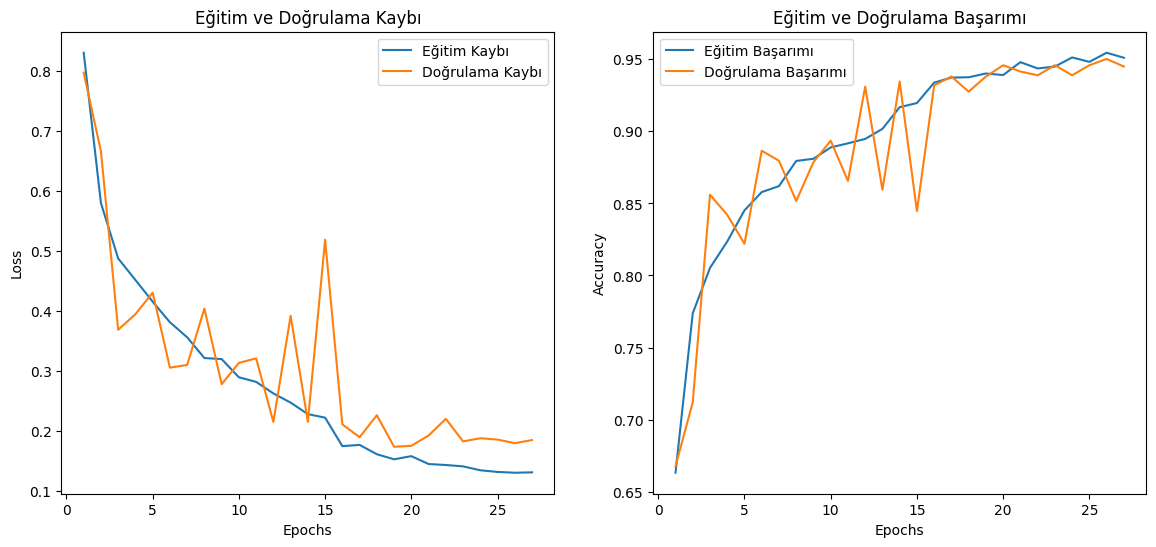

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 6))

# Kayıp (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Başarım (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Eğitim Başarımı')
plt.plot(epochs_range, val_accuracy, label='Doğrulama Başarımı')
plt.title('Eğitim ve Doğrulama Başarımı')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

--- Test Seti Değerlendirmesi ---
164/164 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.9495 - loss: 0.1422
Test Loss: 0.2173
Test Accuracy: %92.14
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      glioma       0.98      0.82      0.89       300
  meningioma       0.83      0.86      0.84       306
     notumor       0.93      0.99      0.96       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



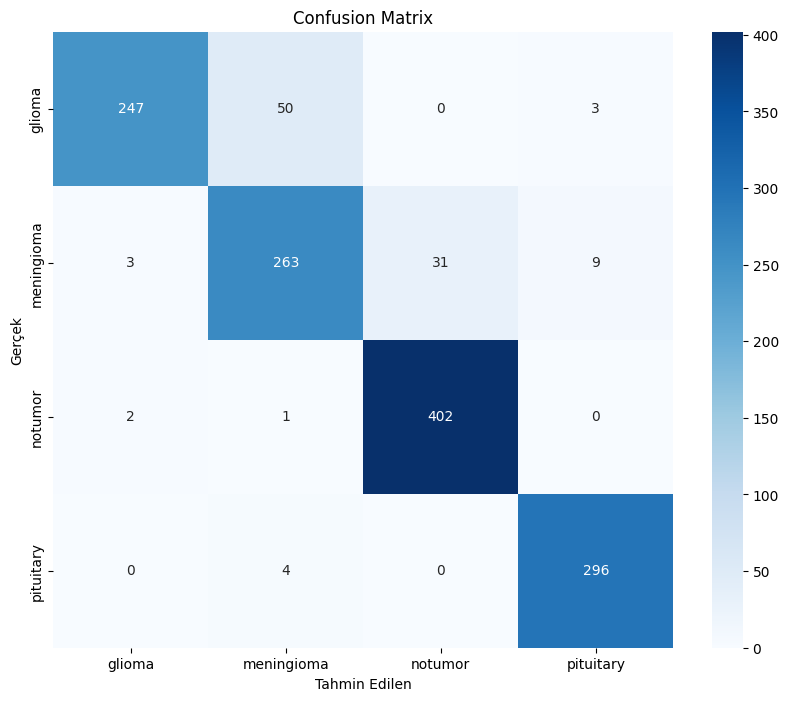

In [ ]:
print("--- Test Seti Değerlendirmesi ---")
results = model.evaluate(test_images, verbose=1)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: %{results[1]*100:.2f}")

y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_images.classes
class_names = list(test_images.class_indices.keys())

print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import cv2
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.cm as cm


print("Test verisi yükleniyor, lütfen bekleyin...")
test_images.reset() 
X_test, y_test_true = [], []


for i in range(len(test_images)):
    batch_x, batch_y = next(test_images)
    X_test.extend(batch_x)
    y_test_true.extend(batch_y)

X_test = np.array(X_test)
y_test_true = np.array(y_test_true) 
y_test_indices = np.argmax(y_test_true, axis=1) 

class_names = list(test_images.class_indices.keys())
print(f"Toplam Test Görüntüsü: {len(X_test)}")
print(f"Sınıflar: {class_names}")

print("Tahminler yapılıyor...")
y_pred_probs = model.predict(X_test, verbose=1)
y_pred_indices = np.argmax(y_pred_probs, axis=1)

Test verisi yükleniyor, lütfen bekleyin...
Toplam Test Görüntüsü: 1311
Sınıflar: ['glioma', 'meningioma', 'notumor', 'pituitary']
Tahminler yapılıyor...
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step


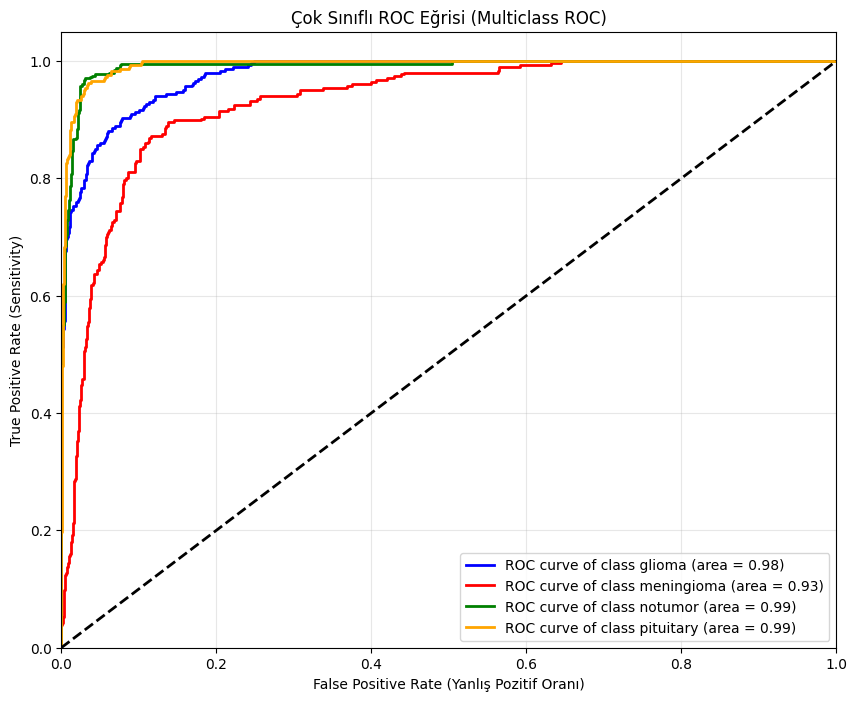

In [ ]:
# --- ROC Eğrisi ve AUC Hesaplama ---
n_classes = len(class_names)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Pozitif Oranı)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Çok Sınıflı ROC Eğrisi (Multiclass ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

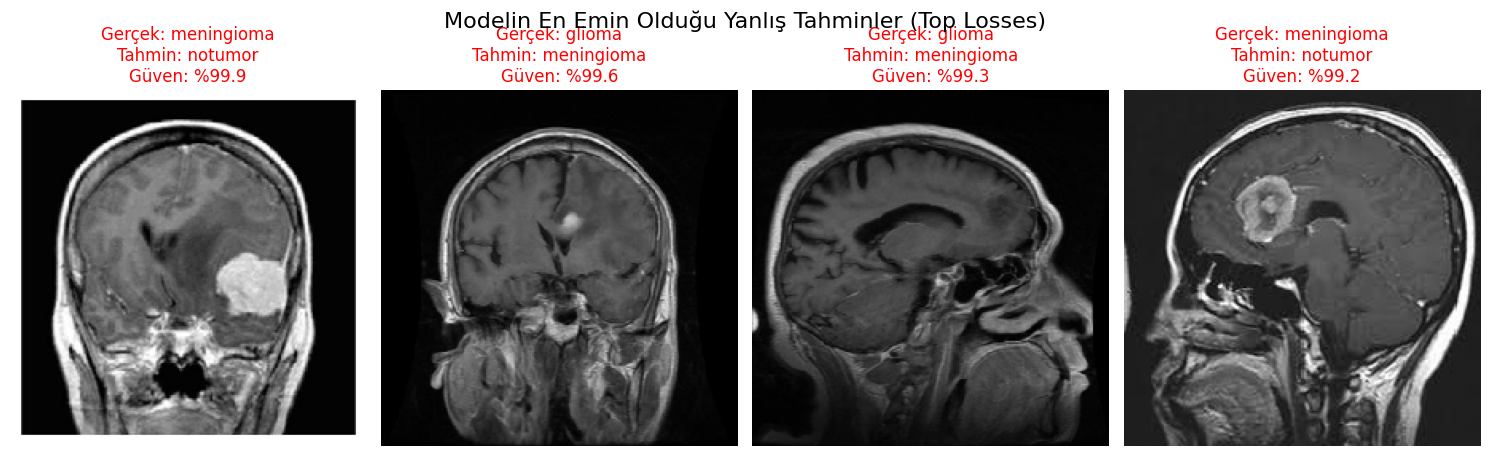

In [ ]:
# --- Hata Analizi: En Yüksek Güvenle Yapılan Yanlışlar ---

# Yanlış tahmin edilenlerin indekslerini bul
incorrect_indices = np.where(y_pred_indices != y_test_indices)[0]


incorrect_probs = np.max(y_pred_probs[incorrect_indices], axis=1)

top_incorrect_sorted = np.argsort(incorrect_probs)[::-1][:4]
top_incorrect_indices = incorrect_indices[top_incorrect_sorted]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(top_incorrect_indices):
    plt.subplot(1, 4, i + 1)

  
    plt.imshow(X_test[idx].reshape(224, 224), cmap='gray')

    true_label = class_names[y_test_indices[idx]]
    pred_label = class_names[y_pred_indices[idx]]
    confidence = np.max(y_pred_probs[idx])

    plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}\nGüven: %{confidence*100:.1f}", color='red')
    plt.axis('off')

plt.suptitle("Modelin En Emin Olduğu Yanlış Tahminler (Top Losses)", fontsize=16)
plt.tight_layout()
plt.show()

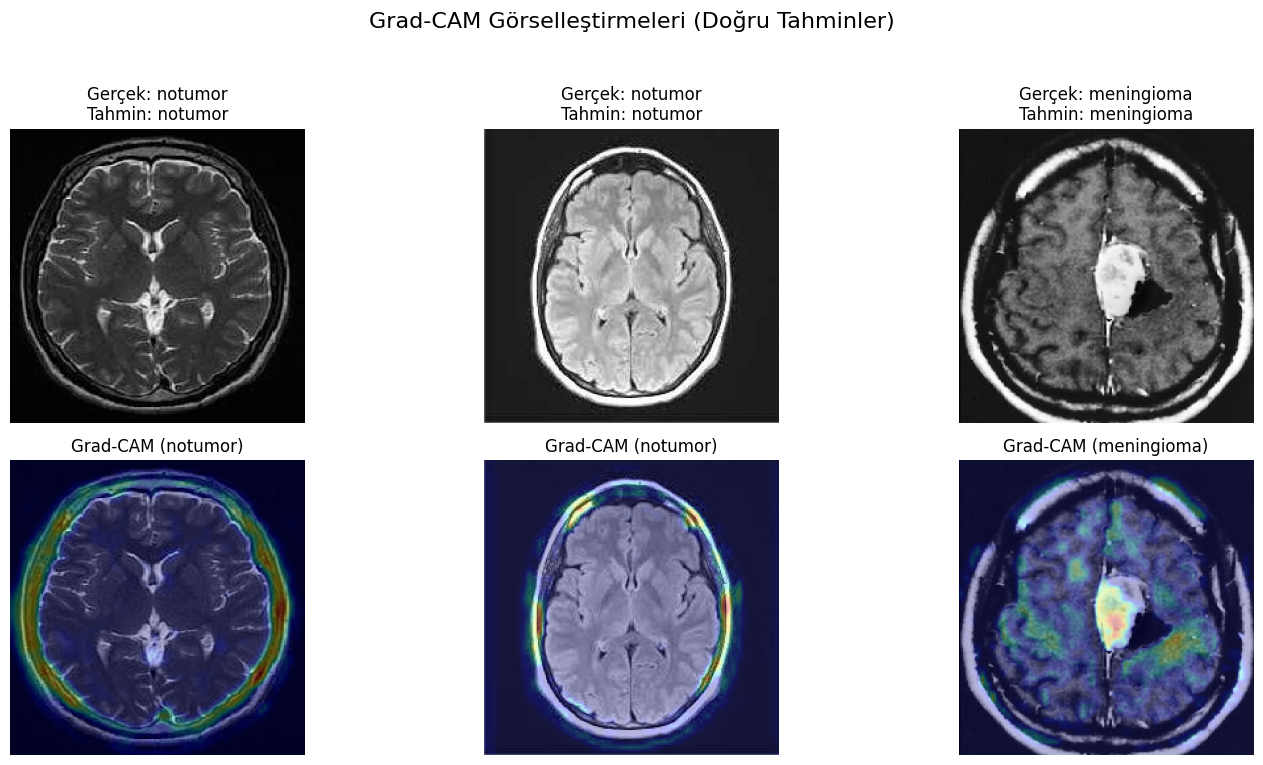

In [ ]:
# --- Grad-CAM Uygulaması ---

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    input_tensor = tf.keras.Input(shape=model.input_shape[1:]) 
   
    x = input_tensor
    conv_output = None
    for layer in model.layers:
        x = layer(x) 
        if layer.name == last_conv_layer_name:
            conv_output = x 

    final_output = x

    grad_model = tf.keras.models.Model(
        inputs=[input_tensor],
        outputs=[conv_output, final_output]
    )

    with tf.GradientTape() as tape:
        
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    
    grads = tape.gradient(class_channel, last_conv_layer_output) 
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]

 
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

 
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


correct_indices = np.where(y_pred_indices == y_test_indices)[0]
sample_indices = np.random.choice(correct_indices, 3, replace=False)

last_conv_layer_name = 'conv2d_3'

plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    img = X_test[idx]
    img_array = np.expand_dims(img, axis=0) 

    original_img_display = (img * 255).astype('uint8')

    pred_index = np.argmax(y_pred_probs[idx])

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)

    heatmap = cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))
    heatmap = np.uint8(255 * heatmap)
   
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    
  
    if original_img_display.shape[-1] == 1:
        original_img_display = np.squeeze(original_img_display, axis=-1)
        original_img_display = cv2.cvtColor(original_img_display, cv2.COLOR_GRAY2BGR)

    
    superimposed_img = jet_heatmap * 0.4 + original_img_display / 255.0 
    superimposed_img = (superimposed_img / np.max(superimposed_img) * 255).astype('uint8')

  
    plt.subplot(2, 3, i + 1)
    plt.imshow(np.squeeze(img), cmap='gray') 
    true_label = class_names[y_test_indices[idx]]
    pred_label = class_names[y_pred_indices[idx]]
    plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}")
    plt.axis('off')

    plt.subplot(2, 3, i + 4) 
    plt.imshow(superimposed_img) 
    plt.title(f"Grad-CAM ({pred_label})")
    plt.axis('off')

plt.suptitle("Grad-CAM Görselleştirmeleri (Doğru Tahminler)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()